## Trend analysis

In [73]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmcrameri.cm as cm

from proteus.config import read_config


In [74]:
import utils.load_grid as lg

In [75]:
pgrid_dir =  "data/output/l9859b_grid2/"
cases = lg.get_cases(pgrid_dir)
ncases = len(cases)

In [76]:
# Case numbers
cnums = ["%d"%int(s.split("_")[-1]) for s in cases]

In [77]:
# Helpfiles
helps, hvars = lg.load_helpfiles(cases)

# Statuses
statuses = lg.get_statuses(pgrid_dir)

# Configuration variables
conf = []
for f in cases:
    conf.append( read_config(f+"/init_coupler.toml") )

print("Done")

Helpfiles: 100%|██████████| 192/192 [00:01<00:00, 145.43it/s]


Done


In [78]:
%matplotlib inline

## Variable1 vs Variable2 scatter plot

In [79]:
def trend_any(x,x_lbl, y,y_lbl, control,
                xscale='linear', yscale='linear', zscale='linear',
                histogram=True, nbins=10, plt_cnums=False):

    fig,ax = plt.subplots(figsize=(5,4))

    ax.set_xlabel(x_lbl)
    ax.set_ylabel(y_lbl)

    xs = []
    ys = []
    cs = [] # colour
    ns = [] # case number
    for i in range(ncases):
        skip_this = False
        for k in control.keys():
            if not np.isclose(lg.descend_get(conf[i],k),control[k]):
                skip_this = True
                break

        if not skip_this:
            # x var
            if '.' in x:
                xs.append(lg.descend_get(conf[i],x))
            else:
                xs.append(lg.access_hvars(hvars,x,-1)[i])

            # y var
            if '.' in y:
                ys.append(lg.descend_get(conf[i],y))
            else:
                ys.append(lg.access_hvars(hvars,y,-1)[i])

            # case number
            ns.append(cnums[i])

            # colour
            if lg.access_hvars(hvars,"Phi_global",-1)[i] < 0.05:
                color='black'
            else:
                color='orange'
            cs.append(color)

    # mask = np.argsort(xs)
    xs = np.array(xs) #[mask]
    ys = np.array(ys) #[mask]
    cs = np.array(cs) #[mask]
    ns = np.array(ns) #[mask]


    if xscale != 'linear':
        if xscale == "log":
            ax.set_xscale("log")
        else:
            ax.set_xscale("symlog", linthresh=np.amin(xs[xs>0]))
        if histogram:
            bins_x = np.logspace(np.log10(np.amin(xs)) , np.log10(np.amax(xs)), nbins)
    else:
        if histogram:
            bins_x = np.linspace(np.amin(xs) , np.amax(xs), nbins)

    if yscale != 'linear':
        if yscale == "log":
            ax.set_yscale("log")
        else:
            ax.set_yscale("symlog",linthresh=np.amin(ys[ys>0]))
        if histogram:
            bins_y = np.logspace(np.log10(np.amin(ys)) , np.log10(np.amax(ys)), nbins)
    else:
        if histogram:
            bins_y = np.linspace(np.amin(ys) , np.amax(ys), nbins)

    if histogram:
        hist,xe,ye,img = ax.hist2d(xs,ys, bins=[bins_x, bins_y], norm=zscale, cmap=cm.oslo_r)
        cax = make_axes_locatable(ax).append_axes('top', size='5%', pad=0.05)
        fig.colorbar(img, cax=cax, orientation='horizontal', location='top')
    else:
        for i in range(len(xs)):

            stat = statuses[int(cnums[i])]
            if 10 <= stat <= 19:
                c = 'k'
                al = 1.0
            else:
                c = 'r'
                al = 0.3

            ax.scatter(xs[i],ys[i], color=cs[i], s=20, alpha=al)

            if plt_cnums:
                ax.text(xs[i], ys[i], cnums[i], color=c,
                        fontsize=10,verticalalignment='center', horizontalalignment='left', zorder=8)

    plt.show()

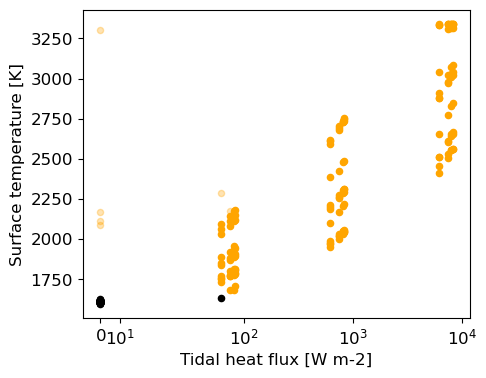

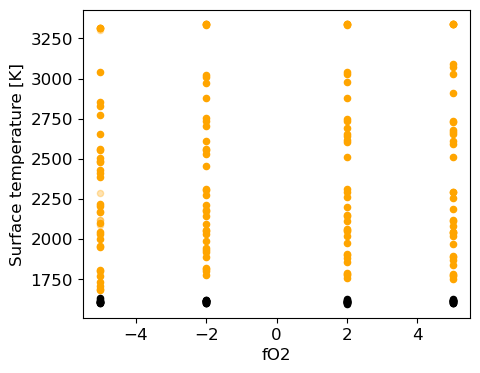

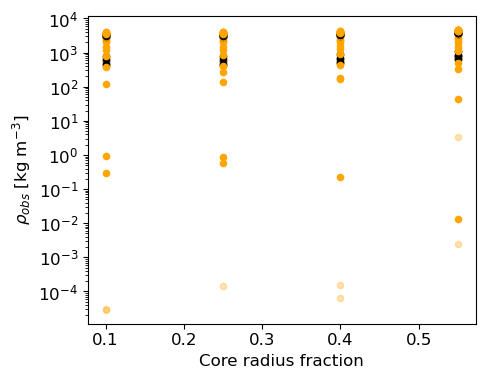

In [86]:
plt.close("all")

trend_any(
    "F_tidal", "Tidal heat flux [W m-2]",
    "T_surf", "Surface temperature [K]",
    control={},
    xscale="symlog",
    yscale="linear",
    zscale="linear",
    histogram=False,
)

trend_any(
    "outgas.fO2_shift_IW", "fO2",
    "T_surf", "Surface temperature [K]",
    control={},
    xscale="linear",
    yscale="linear",
    zscale="linear",
    histogram=False
)

# trend_any(
#     "delivery.elements.H_ppmw", "Hydrogen inventory",
#     "rho_obs", r"$\rho_{obs}$ [kg m$^{-3}$]",
#     control={},
#     xscale="linear",
#     yscale="linear",
#     zscale="linear",
#     histogram=False
# )

trend_any(
    "struct.corefrac", "Core radius fraction",
    "rho_obs", r"$\rho_{obs}$ [kg m$^{-3}$]",
    control={},
    xscale="linear",
    yscale="log",
    zscale="linear",
    histogram=False
)

